# Convolutional Neural Network

Importing the libraries

In [ ]:
import tensorflow as tf
import sys
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [ ]:
from zipfile import ZipFile
file_name = "/content/Dhad-Split.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Part 1 - Data Preprocessing

### Preprocessing the Training set

In [ ]:
train_datagen = ImageDataGenerator (
    rescale = 1./255.,
)
training_set = train_datagen.flow_from_directory (
    "/content/Dhad-Split/train-aug",  
    target_size=(32,32),
    batch_size=256,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    seed=42
)

Found 59872 images belonging to 29 classes.


### Preprocessing the Test set

In [ ]:
val_datagen = ImageDataGenerator (
    rescale=1./255,
)
validation_set = val_datagen.flow_from_directory (
    "/content/Dhad-Split/val",
    target_size=(32,32),
    batch_size=32,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=True,
    seed=42
)

Found 10300 images belonging to 29 classes.


## Part 2 - Building the CNN

### Initialising the CNN

In [ ]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    input_shape = (32, 32, 1),
    filters=64,
    kernel_size=(3,3),
    strides=(1, 1),
    activation="relu",
    padding="same"))

### Step 2 - Pooling

In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),
    strides=2))

### Adding a second convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3,3),
    strides=(1, 1),
    activation="relu",
    padding="same"))

cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),
    strides=2))

### Adding a third convolutional layer

In [ ]:
cnn.add(tf.keras.layers.Conv2D(
    filters=256,
    kernel_size=(3,3),
    strides=(1, 1),
    activation="relu",
    padding="same"))

cnn.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),
    strides=2))

### Dropout

In [ ]:
cnn.add(tf.keras.layers.Dropout(0.3))

### Step 3 - Flattening

In [ ]:
cnn.add(tf.keras.layers.Flatten())

### Dropout

In [ ]:
cnn.add(tf.keras.layers.Dropout(0.3))

### Step 4 - Full Connection

In [ ]:
cnn.add(tf.keras.layers.Dense(units=512, activation="relu"))

### Dropout

In [ ]:
cnn.add(tf.keras.layers.Dropout(0.3))

### Step 4 - Second Full Connection

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1024, activation="relu"))

### Step 5 - Output Layer

In [ ]:
cnn.add(tf.keras.layers.Dense(units=29, activation="Softmax"))

## Part 3 - Training the CNN

### Compiling the CNN

In [ ]:
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Training the CNN on the Training set and evaluating it on the Test set

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy' , patience=6)

In [ ]:
initial_history = cnn.fit(x = training_set, 
                  validation_data = testing_set, 
                  epochs = 100,
                  callbacks=[es_callback]
                  )

Epoch 1/100


## Saving the model

In [ ]:
from keras.models import load_model

cnn.save('/content/drive/MyDrive/Colab Notebooks/CNN-Dhad.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Saving Model History

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(initial_history.history) 

# save to json:  
hist_json_file = '/content/drive/MyDrive/Colab Notebooks/history323-256p6.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = '/content/drive/MyDrive/Colab Notebooks/history323-256p6.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Overfitting Check

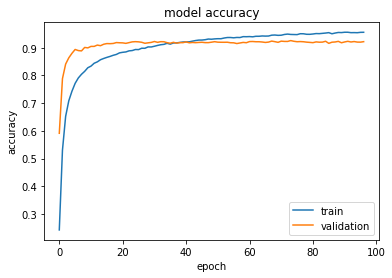

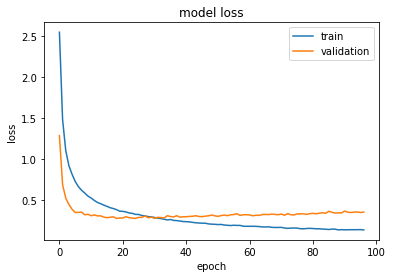

In [ ]:
import matplotlib.pyplot as plt

  #  "Accuracy"
plt.plot(initial_history.history['accuracy'])
plt.plot(initial_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
  # "Loss"
plt.plot(initial_history.history['loss'])
plt.plot(initial_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Part 4 - Making prediction


In [ ]:
from tensorflow.python.ops.metrics import accuracy
import numpy
import sklearn.metrics as metrics
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

test_datagen = ImageDataGenerator (
    rescale=1./255,
)
test_data_generator = test_datagen.flow_from_directory (
    "/content/Dhad-Split/test",
    target_size=(32,32),
    batch_size=32,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=False
)

# define variables 
test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
predictions = cnn.predict(test_data_generator, steps=test_steps_per_epoch)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

# confusion matrix 
confusion_matrix = metrics.confusion_matrix(true_classes, predicted_classes)

# FP, FN, TP, TN
FP = confusion_matrix.sum(axis=0) - numpy.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - numpy.diag(confusion_matrix)
TP = numpy.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# F1-Score
F1 = 2 * ((PPV*TPR)/(PPV+TPR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#######################################################################################################################

per_class = confusion_matrix.diagonal()/confusion_matrix.sum(axis=0)

m_accuracy = accuracy_score(true_classes, predicted_classes)
m_precision = precision_score(true_classes, predicted_classes, average='macro')
m_recall = recall_score(true_classes, predicted_classes, average='macro')
m_f1score = f1_score(true_classes, predicted_classes, average='macro')

w_accuracy = accuracy_score(true_classes, predicted_classes)
w_precision = precision_score(true_classes, predicted_classes, average='weighted')
w_recall = recall_score(true_classes, predicted_classes, average='weighted')
w_f1score = f1_score(true_classes, predicted_classes, average='weighted')

report = {
    'Character': class_labels,
    'Precision':numpy.round(PPV,4) * 100 ,
    'Recall': numpy.round(TPR,4) * 100,
    'F1-Score': numpy.round(F1,4) * 100
    }
df = pd.DataFrame(report)
print(df)
print()

avg = {
    ' ': ['Macro Average', 'Weighted Average'],
    'Precision': [numpy.round(m_precision,4) * 100, numpy.round(w_precision,4) * 100],
    'Recall': [numpy.round(m_recall,4) *100, numpy.round(w_recall,4) * 100],
    'F1-Score': [numpy.round(m_f1score,4) * 100, numpy.round(w_f1score,4) * 100],
    'Accuracy': ['', numpy.round(w_accuracy,4) * 100]
}
dfa = pd.DataFrame(avg)
print(dfa)

Found 10300 images belonging to 29 classes.
322/322 [==============================] - 3s 10ms/step
    Character  Precision  Recall  F1-Score
0      1-alif      98.95   98.78     98.86
1      10-raa      89.25   92.74     90.96
2     11-zeyn      90.82   94.68     92.71
3     12-seen      96.98   95.66     96.32
4    13-sheen      94.72   95.73     95.23
5      14-sad      85.24   89.74     87.43
6     15-dhad      94.54   88.92     91.64
7     16-t'aa      91.52   95.32     93.38
8    17-th'aa      95.16   93.90     94.53
9     18-ayen      84.93   93.18     88.86
10  19-ghayen      94.24   93.53     93.88
11      2-baa      94.78   95.78     95.28
12     20-faa      89.98   91.09     90.53
13    21-ghaf      91.39   94.09     92.72
14     22-kaf      93.95   92.56     93.25
15     23-lam      93.40   91.54     92.46
16    24-meem      93.90   90.54     92.19
17    25-noon      86.51   89.01     87.74
18     26-haa      93.95   96.10     95.01
19     27-waw      93.41   97.70     95.